# Contamination plots

In [1]:
import scanpy as sc
import pandas as pd
import scipy as sp
from plotnine import *
import numpy as np

from tqdm.auto import tqdm

In [ ]:
ad_old = sc.read('../atlas-uncorrected.h5ad')
ad_old = ad_old.raw.to_adata()
ad_old.obs.index.name = None

In [ ]:
ad = sc.read('../atlas.h5ad')
protein_coding_genes = ad.var_names.values
ad = ad.raw.to_adata()

In [7]:
common_idx = sorted(set(ad.obs.index)&set(ad_old.obs.index))
len(common_idx)

204611

In [8]:
gene_common_idx = sorted(set(ad.var_names)&set(ad_old.var_names))
len(gene_common_idx)

30945

In [9]:
ad = ad[common_idx, gene_common_idx].copy()
ad_old = ad_old[common_idx,gene_common_idx].copy()

In [11]:
ad.layers['counts'] = ad.X.copy()

In [13]:
ad_old.layers['counts'] = ad_old.X.copy()
ad_old.obs = ad.obs.copy()

In [14]:
sc.pp.log1p(ad_old)
sc.pp.log1p(ad)

In [15]:
ad.X[:10]

<10x30945 sparse matrix of type '<class 'numpy.float32'>'
	with 10835 stored elements in Compressed Sparse Row format>

In [16]:
%%time

norms = np.linalg.norm(ad_old.X.A - ad.X.A, axis=1)

CPU times: user 23.4 s, sys: 55 s, total: 1min 18s
Wall time: 1min 18s


In [17]:
t2T = ad.obs[['tissue', 'Tissue']].drop_duplicates().set_index('tissue').to_dict()['Tissue']

In [18]:
norm_df = pd.DataFrame(norms, index=ad.obs.index, columns=['norm']).groupby(ad.obs.channel).mean().reset_index()
norm_df['tissue'] = [t2T[x.split('_')[0]] for x in norm_df.channel]
norm_df['prep'] = [x.split('_')[1] for x in norm_df.channel]
norm_df.sort_values('norm')

,channel,norm,tissue,prep
49,lung_CST_GTEX-15CHR,1.844592,Lung,CST
48,lung_CST_GTEX-13N11,2.575090,Lung,CST
53,lung_NST_GTEX-13N11,2.730865,Lung,NST
68,prostate_TST_GTEX-1HSMQ,3.025785,Prostate,TST
58,prostate_CST_GTEX-1HSMQ,3.158466,Prostate,CST
...,...,...,...,...
76,skeletalmuscle_EZ_GTEX-15RIE,9.557361,Skeletal muscle,EZ
39,heart_EZ_GTEX-13N11,10.432194,Heart,EZ
14,esophagusmucosa_EZ_GTEX-15SB6,12.881354,Esophagus mucosa,EZ
77,skeletalmuscle_EZ_GTEX-145ME,13.882318,Skeletal muscle,EZ


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 3 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/Figure-S01-7A.pdf


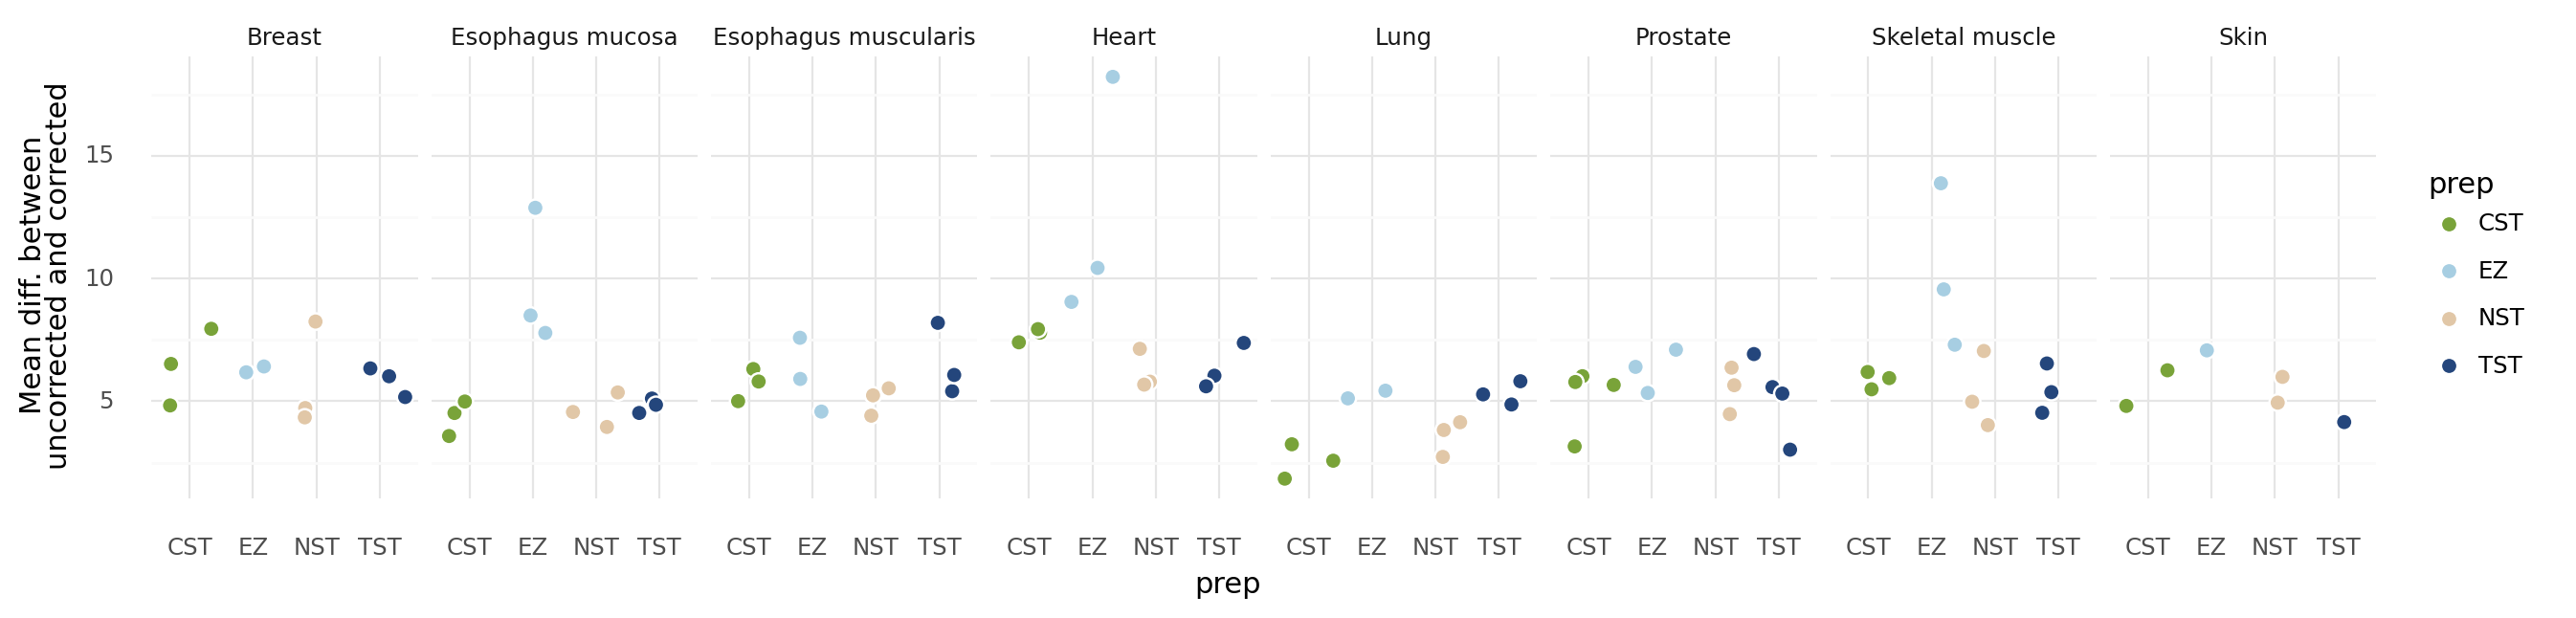

<ggplot: (8752481097415)>

In [19]:
g = (
    ggplot(aes(x='prep', y='norm', fill='prep'), data=norm_df) + geom_jitter(color='white', size=3) +
    facet_grid('~tissue', scales='free_x') +
    theme_minimal() + theme(figure_size=(15,3)) +
    labs(y='Mean diff. between\nuncorrected and corrected') +
    scale_fill_manual(values={'CST': '#79a339', 'EZ': '#a7cee2', 'NST': '#e1c7a7', 'TST': '#24467c'})
)

ggsave(g, 'figures/Figure-S01-7A.pdf')
g

In [20]:
norm_df

,channel,norm,tissue,prep
0,breast_CST_GTEX-1CAMS,7.949613,Breast,CST
1,breast_CST_GTEX-1MCC2,6.519376,Breast,CST
2,breast_CST_GTEX-1R9PN,4.827712,Breast,CST
3,breast_EZ_GTEX-1CAMS,6.177929,Breast,EZ
4,breast_EZ_GTEX-1MCC2,6.416197,Breast,EZ
...,...,...,...,...
85,skin_CST_GTEX-15EOM,6.259219,Skin,CST
86,skin_EZ_GTEX-15EOM,7.072580,Skin,EZ
87,skin_NST_GTEX-1HSMQ,4.941341,Skin,NST
88,skin_NST_GTEX-15EOM,5.992119,Skin,NST


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/Figure-S01-7B.pdf


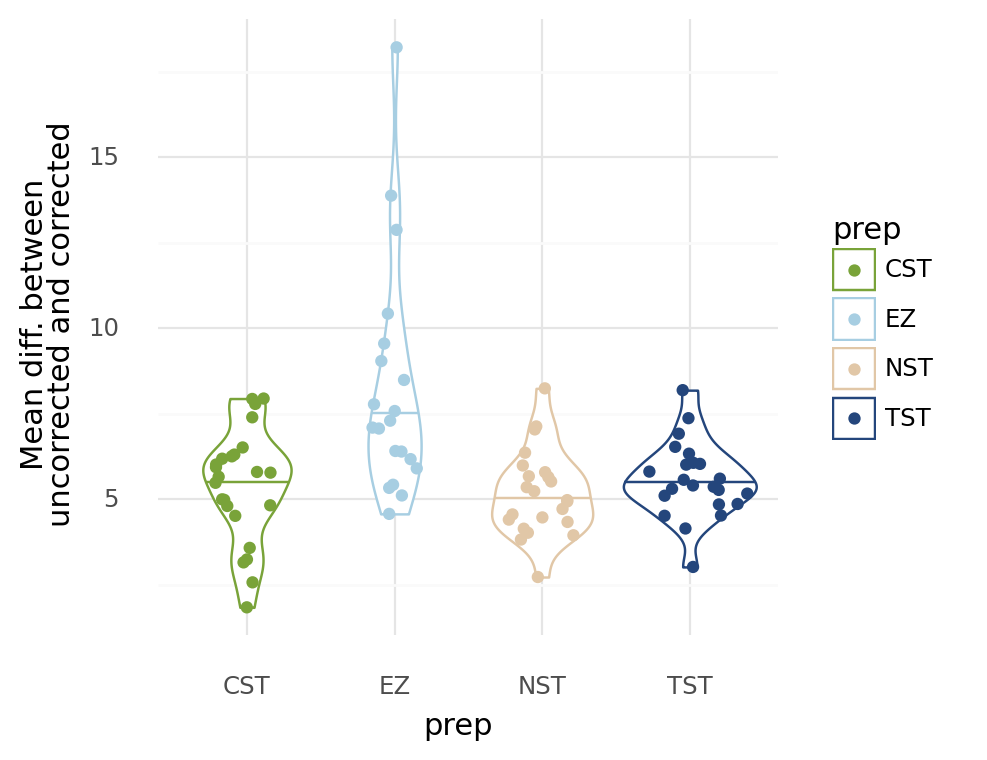

<ggplot: (8753032021782)>

In [21]:
g = (
    ggplot(aes(x='prep', y='norm', color='prep'), data=norm_df) + 
    geom_violin(draw_quantiles=0.5) + geom_sina()  +
    theme_minimal() + theme(figure_size=(4,4))+ 
    labs(y='Mean diff. between\nuncorrected and corrected')+
    scale_color_manual(values={'CST': '#79a339', 'EZ': '#a7cee2', 'NST': '#e1c7a7', 'TST': '#24467c'})
)

ggsave(g, 'figures/Figure-S01-7B.pdf')
g

In [ ]:
ad_old.X.A - ad.X.A

In [ ]:
norm_df = pd.DataFrame(ad_old.X.A - ad.X.A, index=ad.obs.index, columns=['norm']).groupby(ad.obs.channel).mean().reset_index()
norm_df['tissue'] = [t2T[x.split('_')[0]] for x in norm_df.channel]
norm_df['prep'] = [x.split('_')[1] for x in norm_df.channel]
norm_df.sort_values('norm')

g = (
    ggplot(aes(x='prep', y='norm', fill='prep'), data=norm_df) + geom_jitter(color='white', size=3) +
    facet_grid('~tissue', scales='free_x') +
    theme_minimal() + theme(figure_size=(15,3)) +
    labs(y='Mean diff. between\nuncorrected and corrected') +
    scale_fill_manual(values={'CST': '#79a339', 'EZ': '#a7cee2', 'NST': '#e1c7a7', 'TST': '#24467c'})
)

#ggsave(g, 'figures/Figure-S01-7A.pdf')
g

norm_df

g = (
    ggplot(aes(x='prep', y='norm', color='prep'), data=norm_df) + 
    geom_violin(draw_quantiles=0.5) + geom_sina()  +
    theme_minimal() + theme(figure_size=(4,4))+ 
    labs(y='Mean diff. between\nuncorrected and corrected')+
    scale_color_manual(values={'CST': '#79a339', 'EZ': '#a7cee2', 'NST': '#e1c7a7', 'TST': '#24467c'})
)

#ggsave(g, 'figures/Figure-S01-7B.pdf')
g

In [32]:
preps =  ['CST', 'EZ', 'NST', 'TST']
for i, prep in enumerate(preps):
    for prep2 in preps[(i+1):]:
        print(prep, ' vs ', prep2)
        print(sp.stats.ttest_ind(norm_df[norm_df.prep == prep].norm, norm_df[norm_df.prep == prep2].norm))

CST  vs  EZ
Ttest_indResult(statistic=-3.6087760961868103, pvalue=0.0008125091870469197)
CST  vs  NST
Ttest_indResult(statistic=0.5153518169267481, pvalue=0.6088297963145324)
CST  vs  TST
Ttest_indResult(statistic=-0.41011493279509903, pvalue=0.6836676646741505)
EZ  vs  NST
Ttest_indResult(statistic=4.012939796163045, pvalue=0.0002485446205251282)
EZ  vs  TST
Ttest_indResult(statistic=3.5554834464559684, pvalue=0.0009677777316415608)
NST  vs  TST
Ttest_indResult(statistic=-1.123767721847805, pvalue=0.26720551047170393)


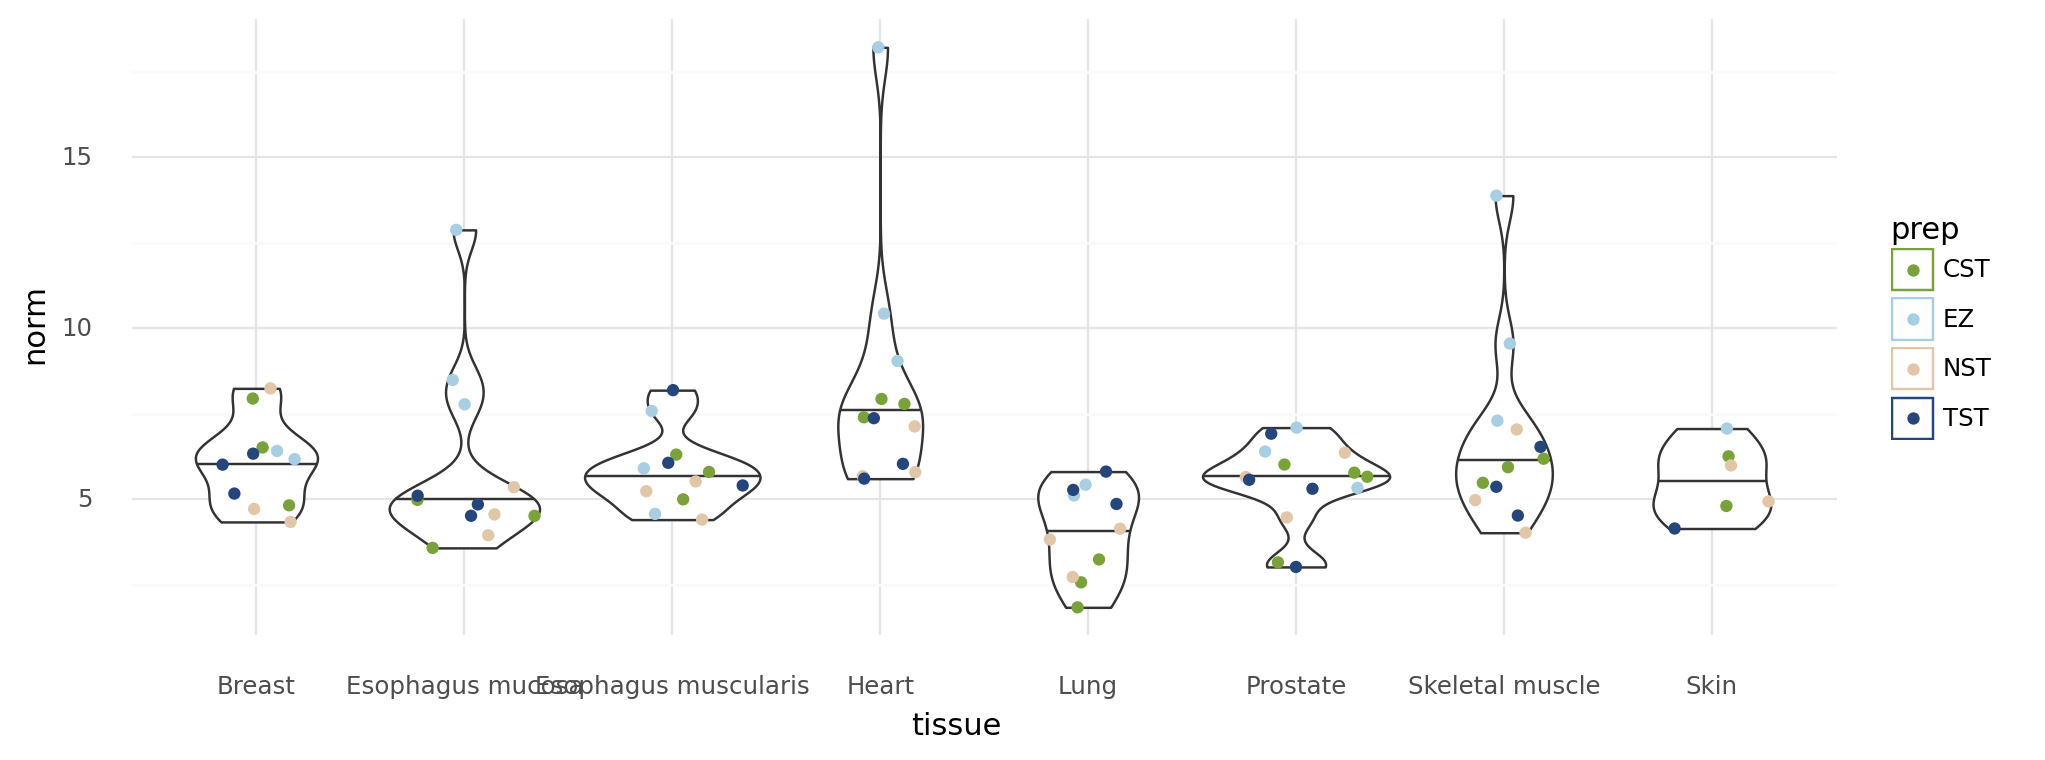

<ggplot: (8748913707987)>

In [27]:
(
    ggplot(aes(x='tissue', y='norm', color='prep', group='tissue'), data=norm_df) + 
    geom_violin(draw_quantiles=0.5) + geom_sina()  +
    theme_minimal() + theme(figure_size=(11,4)) + 
    scale_color_manual(values={'CST': '#79a339', 'EZ': '#a7cee2', 'NST': '#e1c7a7', 'TST': '#24467c'})
)

In [33]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
norm_df.prep = pd.Categorical(norm_df.prep, categories=['TST', 'CST', 'EZ', 'NST'])
norm_df.tissue = pd.Categorical(norm_df.tissue, categories=['Lung', 'Breast', 'Esophagus mucosa', 'Esophagus muscularis', 'Heart', 'Prostate', 'Skeletal muscle', 'Skin'])

In [35]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('norm ~ prep', data=norm_df).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   norm   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.71
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           4.71e-06
Time:                        13:37:30   Log-Likelihood:                -187.96
No. Observations:                  90   AIC:                             383.9
Df Residuals:                      86   BIC:                             393.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5686      0.417     13.366      

In [36]:
from statsmodels.stats.multitest import multipletests

In [37]:
pval_df  = pd.DataFrame(results.summary2().tables[1])

s, p, _, _ = multipletests(pval_df['P>|t|'].values, method='fdr_bh')
pval_df['sign'] = s
pval_df['FDR'] = p

pval_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],sign,FDR
Intercept,5.568602,0.416633,13.365728,1.060423e-22,4.740363,6.396841,True,4.241692e-22
prep[T.CST],-0.168338,0.583038,-0.288725,7.734865e-01,-1.327379,0.990703,False,7.734865e-01
prep[T.EZ],2.667027,0.610904,4.365707,3.514206e-05,1.452590,3.881463,True,7.028413e-05
prep[T.NST],-0.388613,0.589208,-0.659551,5.113043e-01,-1.559919,0.782694,False,6.817391e-01


In [38]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('norm ~ tissue', data=norm_df).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   norm   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     3.603
Date:                Fri, 04 Jun 2021   Prob (F-statistic):            0.00197
Time:                        13:37:32   Log-Likelihood:                -190.18
No. Observations:                  90   AIC:                             396.4
Df Residuals:                      82   BIC:                             416.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [39]:
from statsmodels.stats.multitest import multipletests

In [40]:
pval_df  = pd.DataFrame(results.summary2().tables[1])

s, p, _, _ = multipletests(pval_df['P>|t|'].values, method='fdr_bh')
pval_df['sign'] = s
pval_df['FDR'] = p

pval_df

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],sign,FDR
Intercept,4.079038,0.632378,6.450314,7.297131e-09,2.821036,5.337040,True,5.837705e-08
tissue[T.Breast],1.986919,0.894318,2.221714,2.905819e-02,0.207836,3.766002,False,5.811637e-02
tissue[T.Esophagus mucosa],1.804271,0.875488,2.060874,4.248438e-02,0.062646,3.545895,False,6.407367e-02
tissue[T.Esophagus muscularis],1.757017,0.875488,2.006900,4.805525e-02,0.015392,3.498641,False,6.407367e-02
tissue[T.Heart],4.125591,0.875488,4.712333,9.880779e-06,2.383966,5.867215,True,3.952312e-05
tissue[T.Prostate],1.405563,0.845051,1.663288,1.000726e-01,-0.275513,3.086638,False,1.143686e-01
tissue[T.Skeletal muscle],2.658132,0.875488,3.036172,3.211253e-03,0.916507,4.399756,True,8.563341e-03
tissue[T.Skin],1.458169,1.064451,1.369879,1.744642e-01,-0.659364,3.575701,False,1.744642e-01


In [41]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('norm ~ prep+tissue', data=norm_df).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   norm   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     7.475
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.04e-08
Time:                        13:37:40   Log-Likelihood:                -172.28
No. Observations:                  90   AIC:                             366.6
Df Residuals:                      79   BIC:                             394.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Per-gene differences

In [42]:
%%time

pergene_df = pd.DataFrame((ad_old.X.A - ad.X.A), index=ad.obs.index, columns=ad.var_names).groupby(ad.obs.Tissue).mean(0).reset_index().melt(id_vars='Tissue', var_name='gene', value_name='meandiff')
pergene_df = pergene_df[pergene_df.meandiff>0].reset_index(drop=True)

#pergene_df['tissue'] = [x.split('_')[0] for x in pergene_df.channel]
#pergene_df['prep'] = [x.split('_')[1] for x in pergene_df.channel]

CPU times: user 36.7 s, sys: 58.8 s, total: 1min 35s
Wall time: 1min 35s


In [43]:
top100 = []

for t in pergene_df.Tissue.unique():
    df = pergene_df[pergene_df.gene.isin(protein_coding_genes) & (pergene_df.Tissue == t)].sort_values('meandiff', ascending=False).head(100)
    top100.append(df)
    
top100 = pd.concat(top100, axis=0).reset_index(drop=True)

In [44]:
exc_genes = top100.groupby('gene')['Tissue'].count().sort_values()
exc_genes = exc_genes[exc_genes>4].index

top100 = top100[~top100.gene.isin(exc_genes)]

In [45]:
top20 = []

for t in top100.Tissue.unique():
    df = top100[top100.gene.isin(protein_coding_genes) & (top100.Tissue == t)].sort_values('meandiff', ascending=False).head(20)
    top20.append(df)
    
top20 = pd.concat(top20, axis=0).reset_index(drop=True)
top20['genet'] = top20.gene.astype(str) + '|' + top20.Tissue.astype(str)

In [46]:
de_broad = pd.read_pickle('../DE/de_broad.pkl')
de_broad = de_broad[(de_broad.celltype !='Unknown')].reset_index(drop=True)
de_broad

,celltype,gene,tstat,pvals,pvals_fdr,log2FC,fraction_group,fraction_rest,mean_expressed,spring_score,tissue,marker,spring_score_nonzero,significant
0,Adipocyte,ACACB,116.096718,0.000000e+00,0.000000e+00,7.396634,0.989211,0.050318,2.250690,1.919520,Breast,,1.919520,True
1,Adipocyte,FASN,73.292519,0.000000e+00,0.000000e+00,5.755496,0.904032,0.066925,1.596257,1.687813,Breast,,1.687813,True
2,Adipocyte,LPIN1,69.214905,0.000000e+00,0.000000e+00,5.580588,0.891539,0.073043,1.470428,1.661884,Breast,Adipocyte,1.661884,True
3,Adipocyte,MLXIPL,68.294312,0.000000e+00,0.000000e+00,7.636932,0.856899,0.009989,1.058315,1.724225,Breast,,1.724225,True
4,Adipocyte,EBF1,65.268257,0.000000e+00,0.000000e+00,4.079791,0.899489,0.123236,1.321814,1.397531,Breast,Adipocyte,1.397531,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855446,Sweat gland cell,CLDN1,-23.766817,5.793523e-102,7.509371e-99,-4.402716,0.016667,0.244679,0.693147,-0.454077,Skin,,0.000000,False
1855447,Sweat gland cell,TP63,-23.973349,2.741841e-103,4.738510e-100,-4.625478,0.013333,0.254028,0.794513,-0.458739,Skin,Basal Keratinocyte,0.000000,False
1855448,Sweat gland cell,COL17A1,-25.999702,6.763410e-115,2.629952e-111,-4.302104,0.020000,0.291426,1.011404,-0.513092,Skin,,0.000000,False
1855449,Sweat gland cell,LAMB4,-27.023550,3.902433e-127,3.034922e-123,-5.010974,0.010000,0.271335,1.059351,-0.504338,Skin,,0.000000,False


In [47]:
idx = de_broad.groupby(['gene', 'tissue'], observed=True)['log2FC'].idxmax()
idx = idx[~pd.isnull(idx)]
de = de_broad.loc[idx.astype(int)][['celltype', 'gene', 'tissue']].sort_values(['gene', 'tissue', 'celltype'])
de

,celltype,gene,tissue
49808,Epithelial cell (luminal),A1BG,Breast
246722,Immune (DC),A1BG,Esophagus mucosa
631601,Schwann cell,A1BG,Esophagus muscularis
849635,Schwann cell,A1BG,Heart
1103773,Pericyte/SMC,A1BG,Lung
...,...,...,...
715959,Immune (B cell),ZZZ3,Heart
934124,Epithelial cell (basal),ZZZ3,Lung
1188603,Epithelial cell (club),ZZZ3,Prostate
1393109,Adipocyte,ZZZ3,Skeletal muscle


In [48]:
top20 = top20.merge(de.rename(columns={'tissue': 'Tissue'}), how='left')
top20

,Tissue,gene,meandiff,genet,celltype
0,Breast,KRT15,0.209154,KRT15|Breast,Epithelial cell (luminal)
1,Breast,CIRBP,0.206992,CIRBP|Breast,Epithelial cell (luminal)
2,Breast,FASN,0.133589,FASN|Breast,Adipocyte
3,Breast,KRT7,0.131695,KRT7|Breast,Epithelial cell (luminal)
4,Breast,SRRM2,0.128265,SRRM2|Breast,Adipocyte
...,...,...,...,...,...
155,Skin,CROCC,0.046533,CROCC|Skin,Endothelial cell (lymphatic)
156,Skin,KRT15,0.046514,KRT15|Skin,Sweat gland cell
157,Skin,CLK1,0.044846,CLK1|Skin,Immune (mast cell)
158,Skin,ITGB4,0.042074,ITGB4|Skin,Epithelial cell (basal keratinocyte)


In [49]:
fill_dict = {k:v for k,v in zip(ad.obs['Broad cell type'].cat.categories, ad.uns['Broad cell type_colors']) if k != 'Unknown'}

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 20 x 5 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/Figure-S01-7C.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:409: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:415: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/facets/facet.py:409: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/gokcen/.miniconda3/lib/p

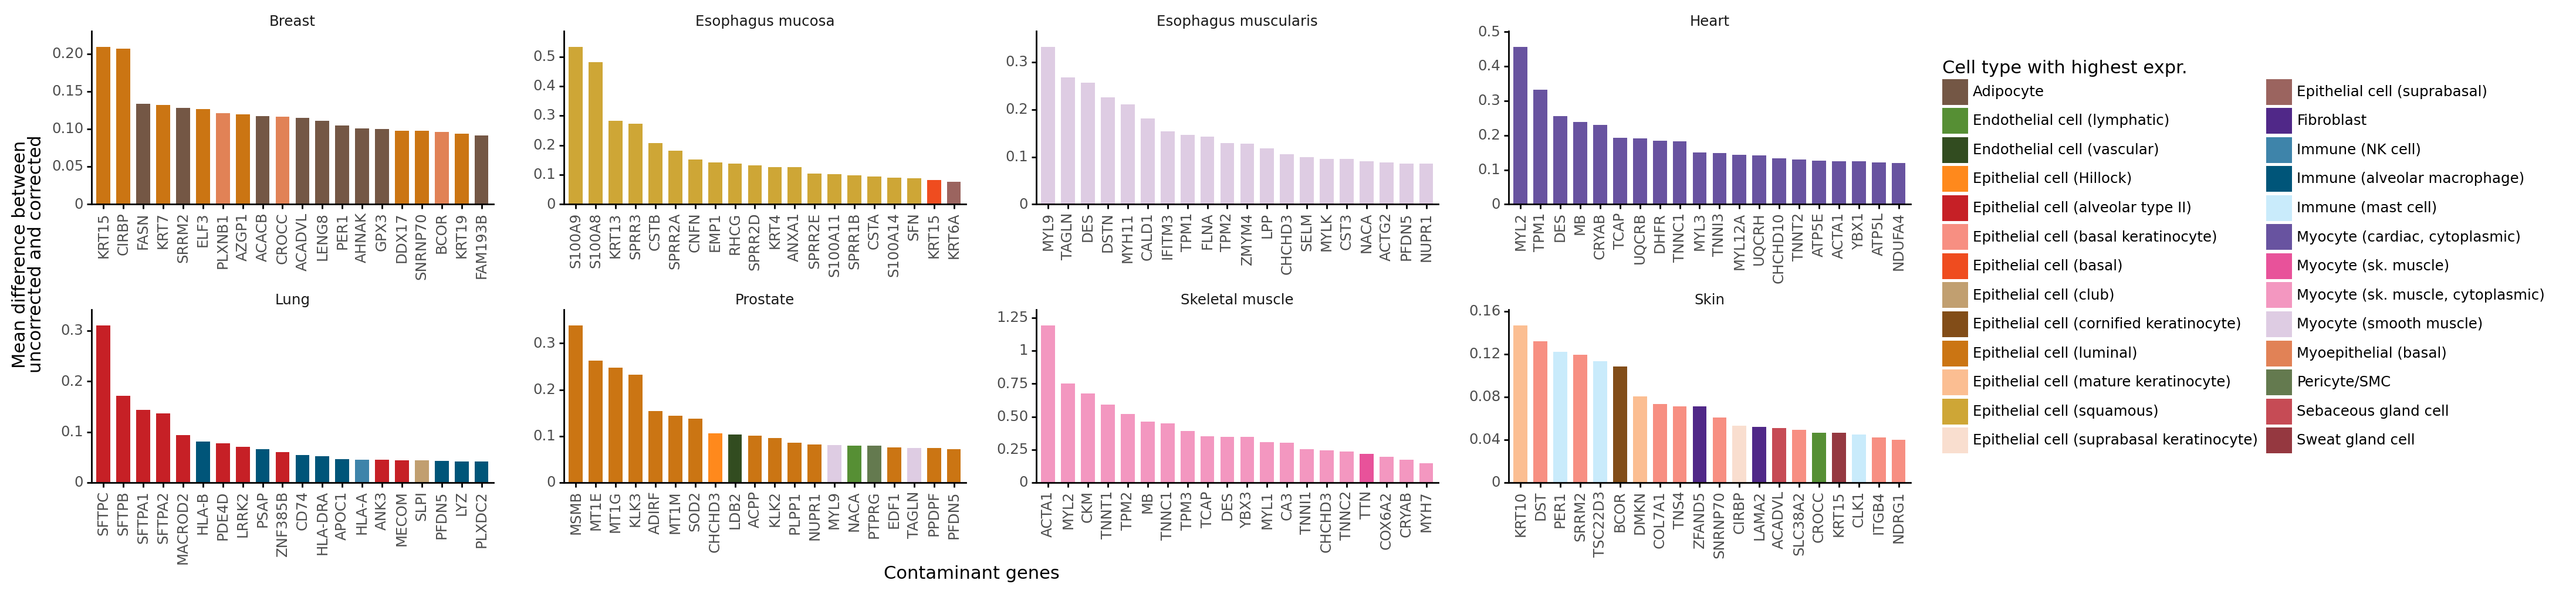

<ggplot: (8750165182088)>

In [61]:
g = (
    ggplot(aes(x='reorder(genet, -meandiff)', y='meandiff'), data=top20) + 
    geom_bar(aes(fill='celltype'), stat='identity', width=0.7) +
    facet_wrap('Tissue', ncol=4, scales='free') +
    scale_x_discrete(labels=lambda x: [i.split('|')[0] for i in x.keys()]) +
    scale_y_continuous(expand=[0,0, 0.1, 0]) +
    scale_fill_manual(values=fill_dict, na_value='lightgray') +
    labs(x='Contaminant genes', y='Mean difference between\nuncorrected and corrected', fill='Cell type with highest expr.') +
    theme_classic() + 
    theme(
        figure_size=(20,5),
        axis_text_x=element_text(angle=90), 
        panel_grid=element_blank(), 
        panel_spacing_y=0.7,
        panel_spacing_x=0.6,
        strip_background=element_blank(),
    )
)

ggsave(g, 'figures/Figure-S01-7C.pdf')
g

In [372]:
top20

,Tissue,gene,meandiff,genet,celltype
0,Breast,KRT15,0.209154,KRT15|Breast,Epithelial cell (luminal)
1,Breast,CIRBP,0.206992,CIRBP|Breast,Epithelial cell (luminal)
2,Breast,FASN,0.133589,FASN|Breast,Adipocyte
3,Breast,KRT7,0.131695,KRT7|Breast,Epithelial cell (luminal)
4,Breast,SRRM2,0.128265,SRRM2|Breast,Adipocyte
...,...,...,...,...,...
155,Skin,CROCC,0.046533,CROCC|Skin,Endothelial cell (lymphatic)
156,Skin,KRT15,0.046514,KRT15|Skin,Sweat gland cell
157,Skin,CLK1,0.044846,CLK1|Skin,Immune (mast cell)
158,Skin,ITGB4,0.042074,ITGB4|Skin,Epithelial cell (basal keratinocyte)


In [374]:
sc.set_figure_params(dpi=100)

## Dotplots

In [62]:
import string

In [65]:
string.ascii_uppercase[3:]

'DEFGHIJKLMNOPQRSTUVWXYZ'

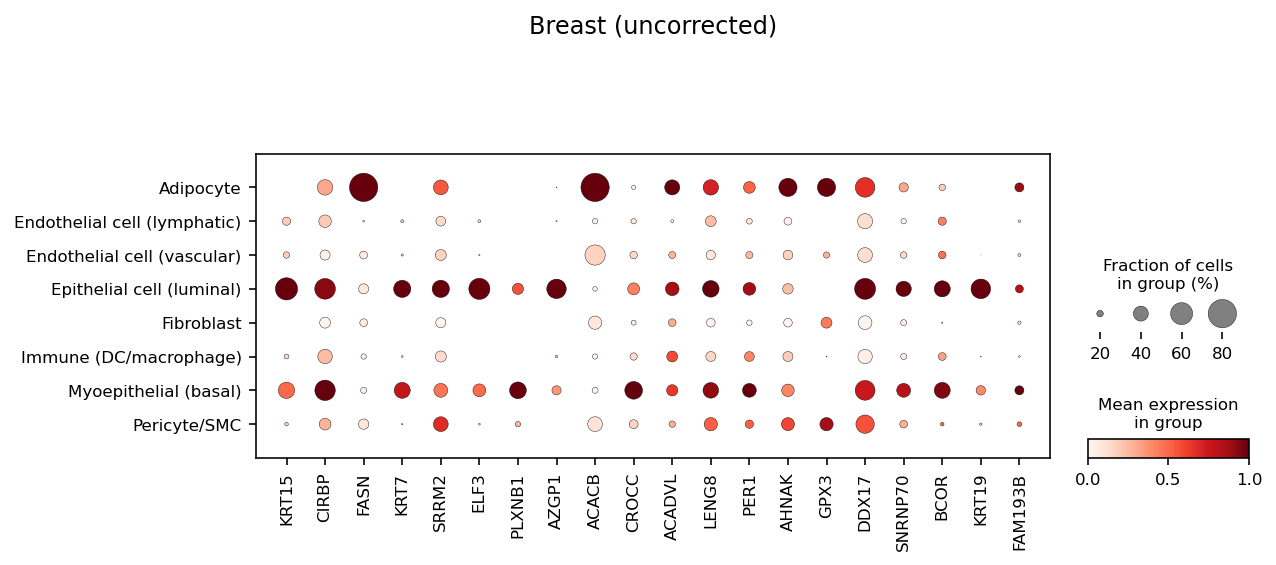

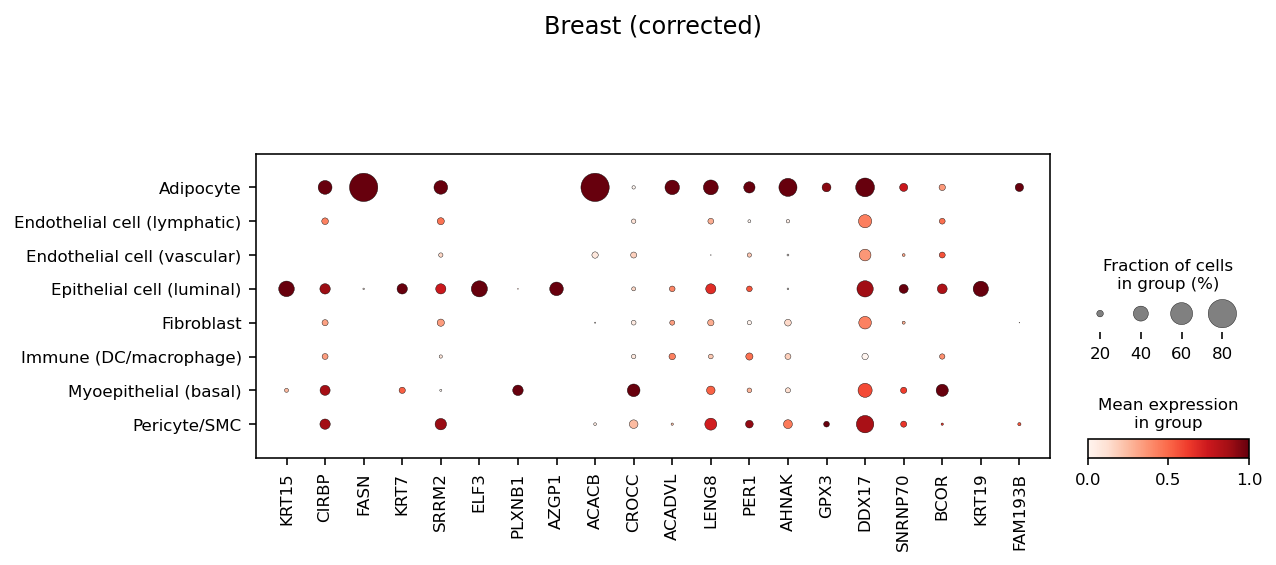

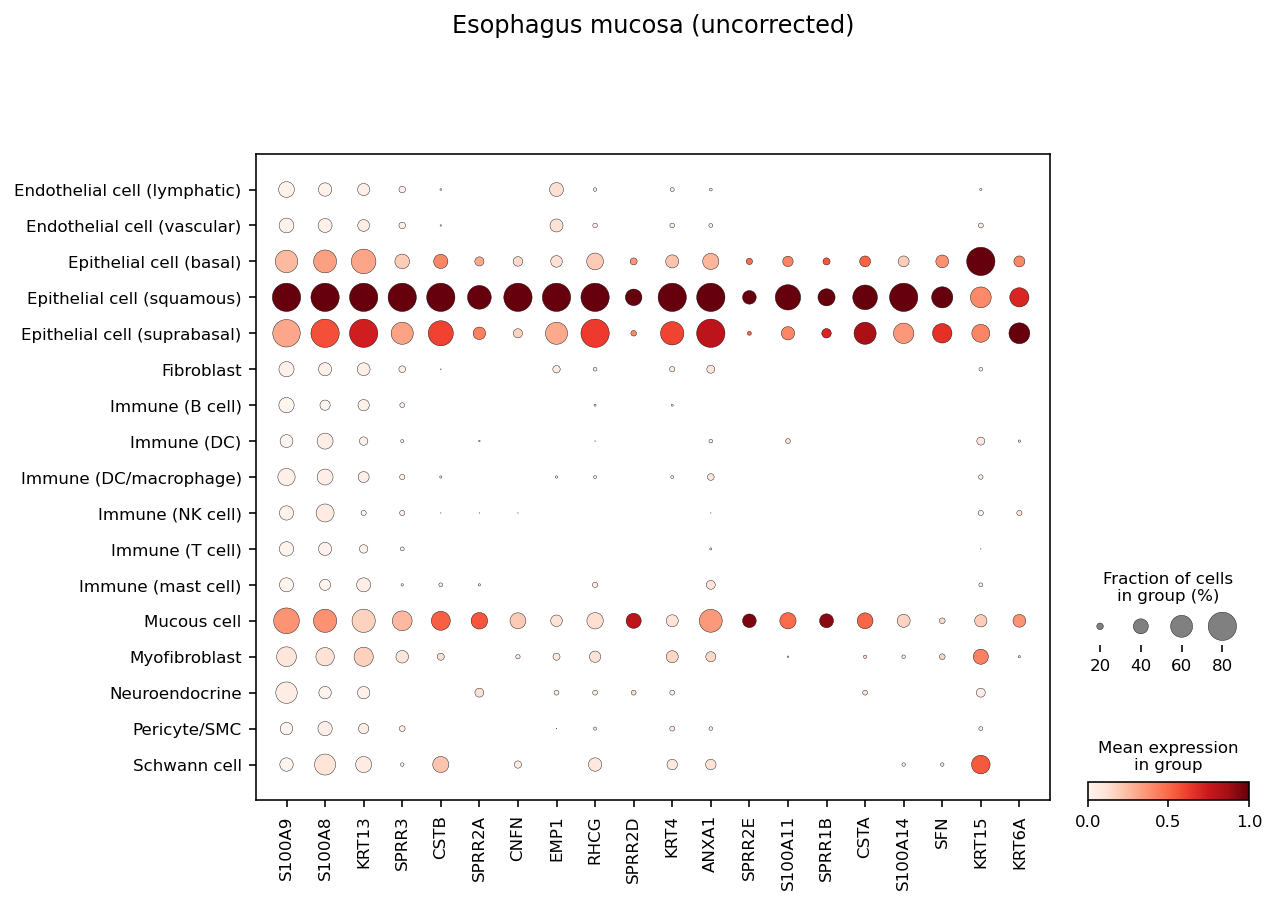

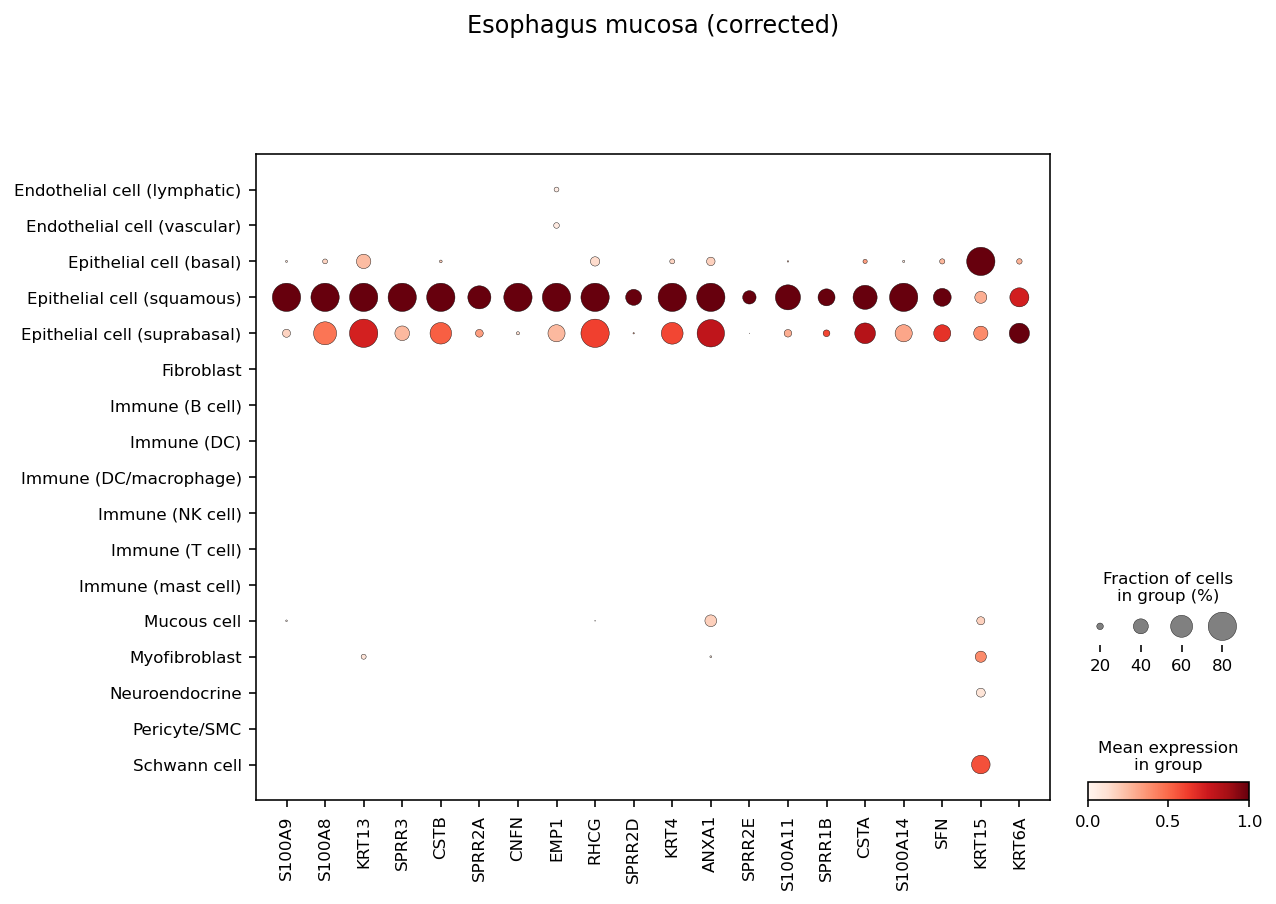

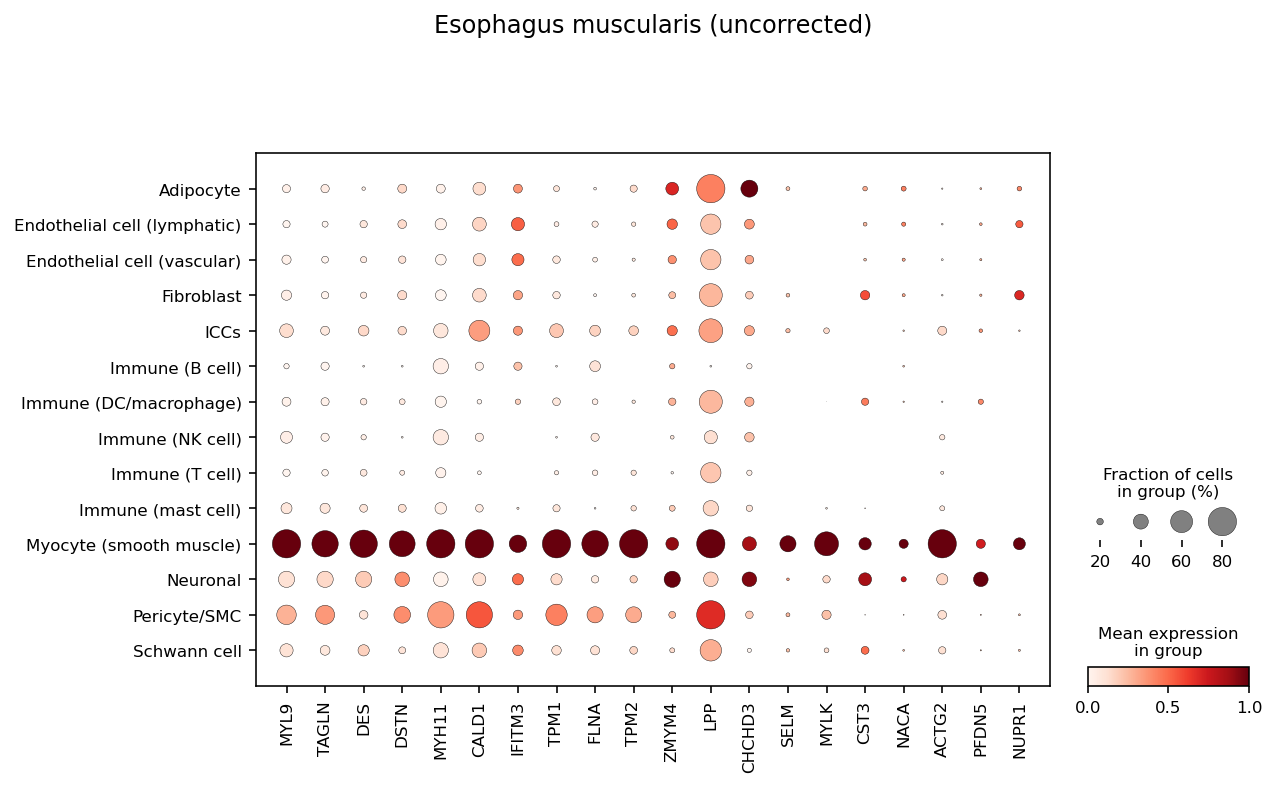

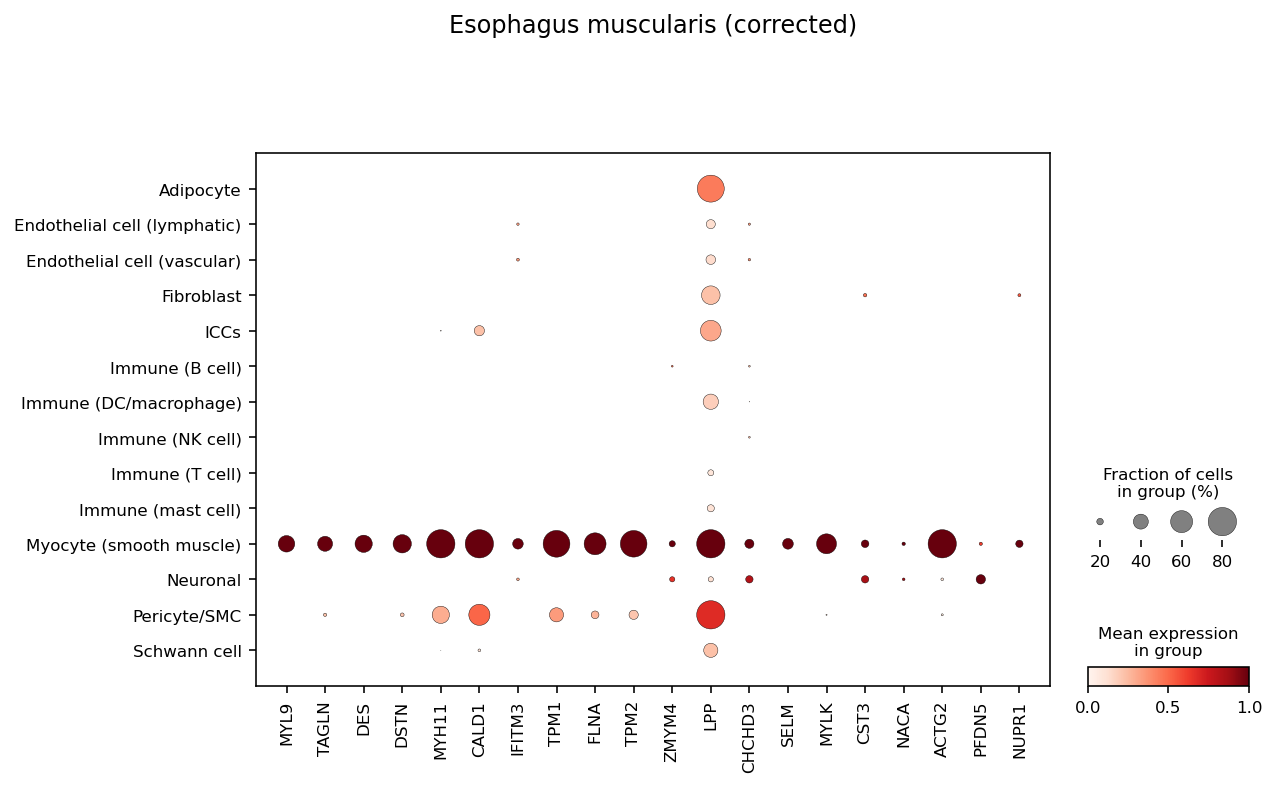

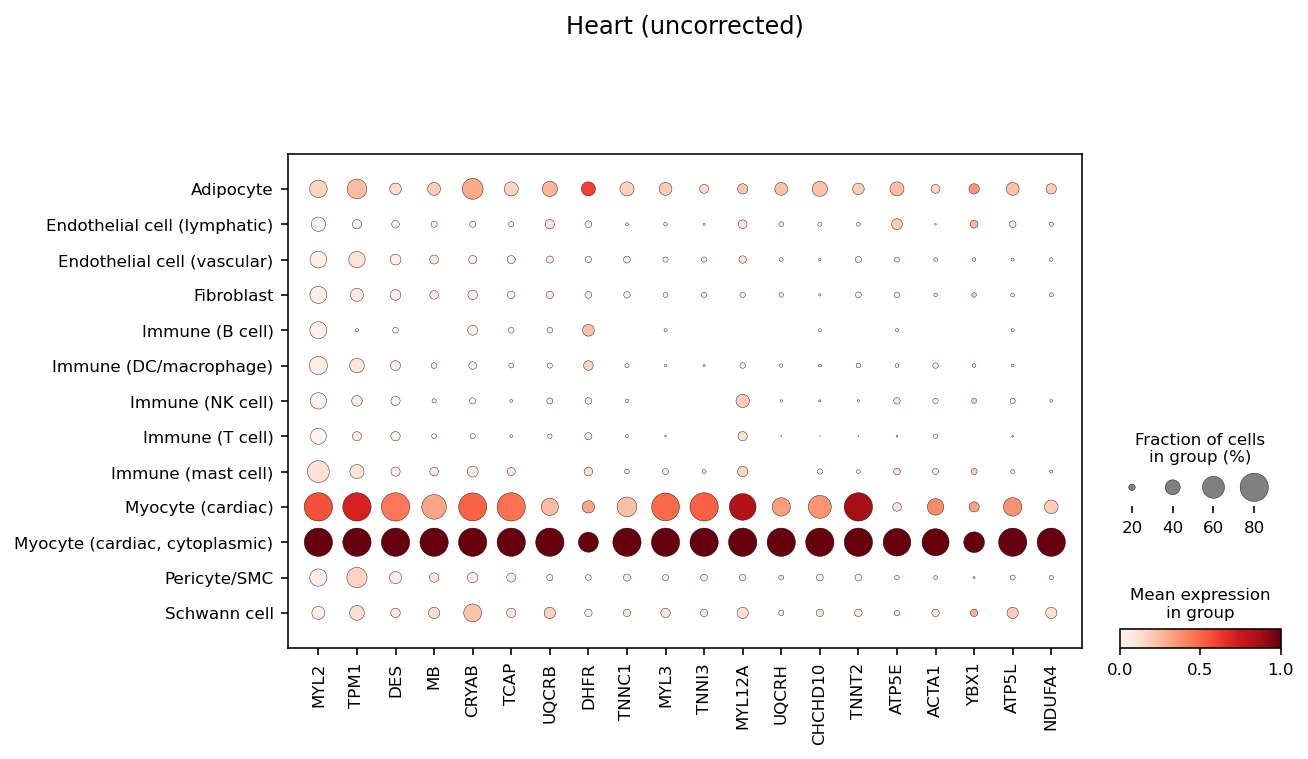

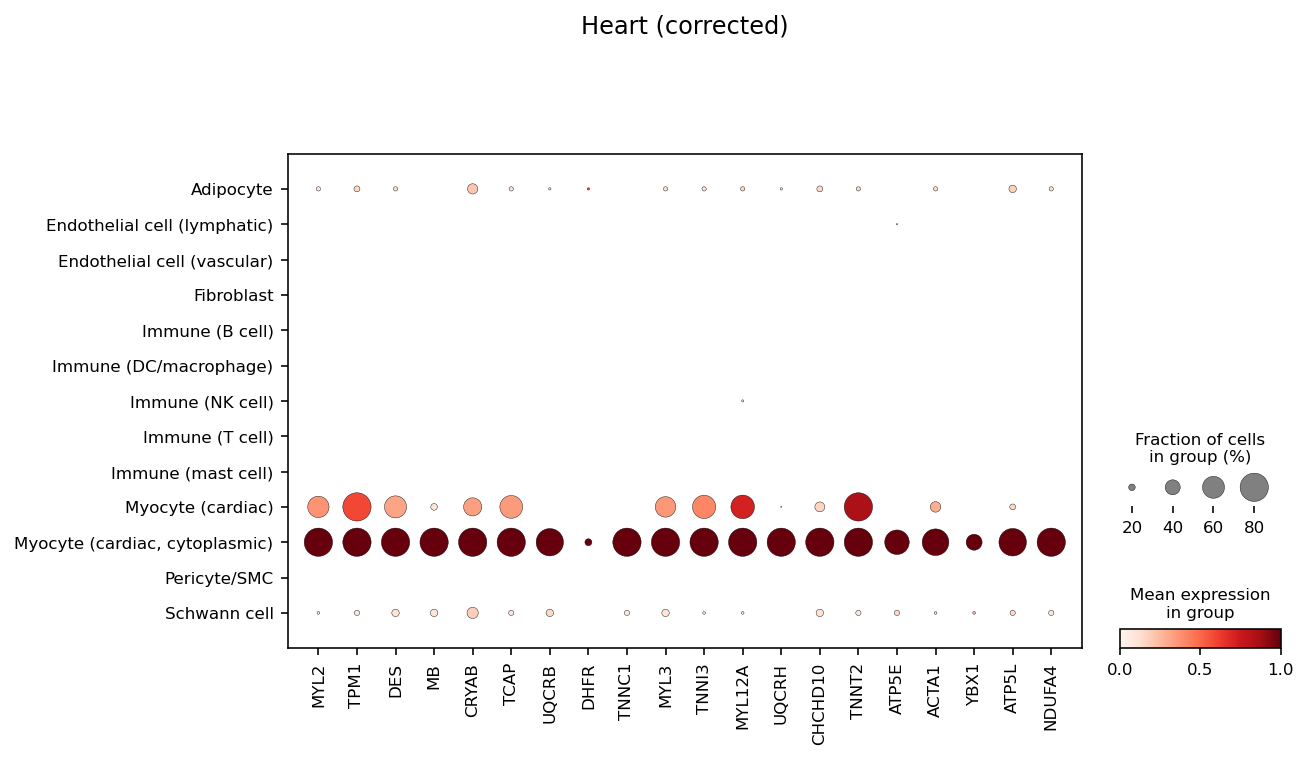

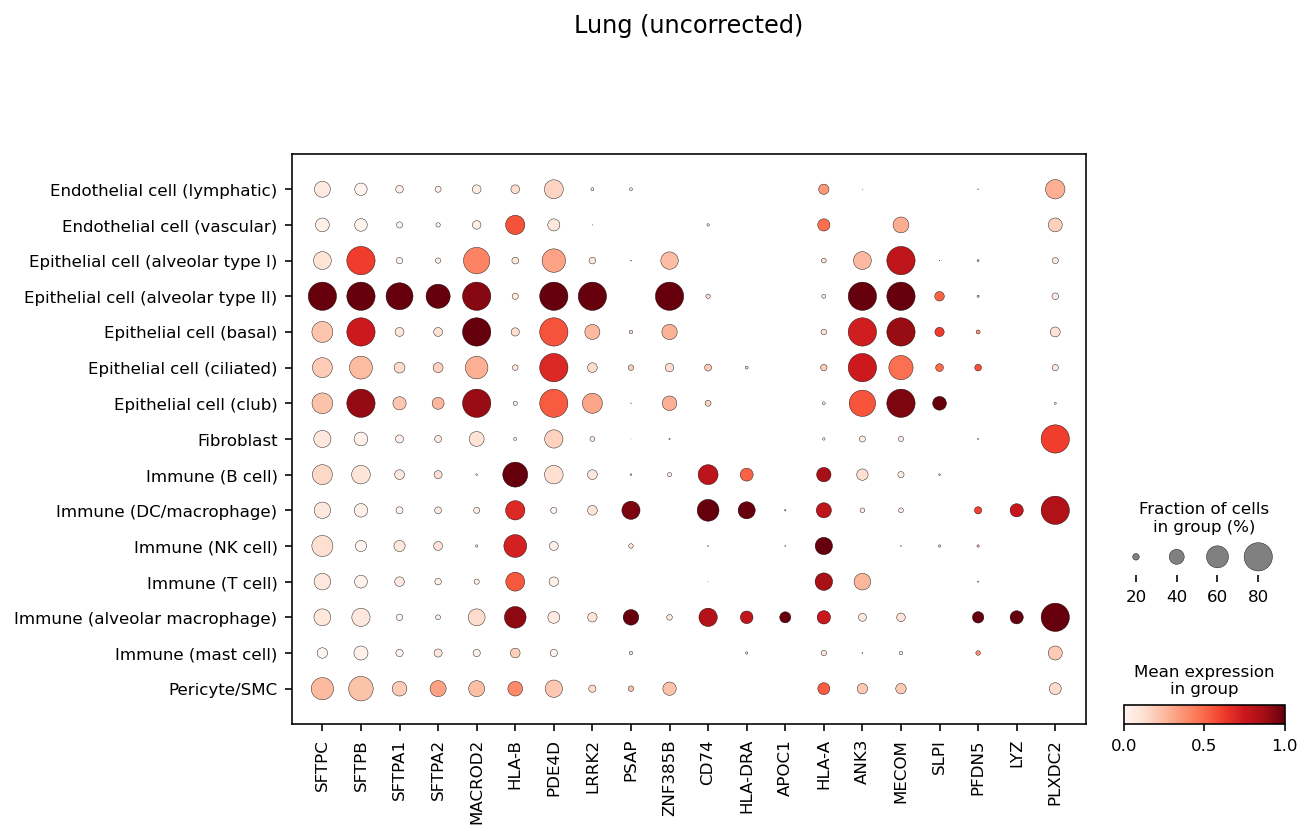

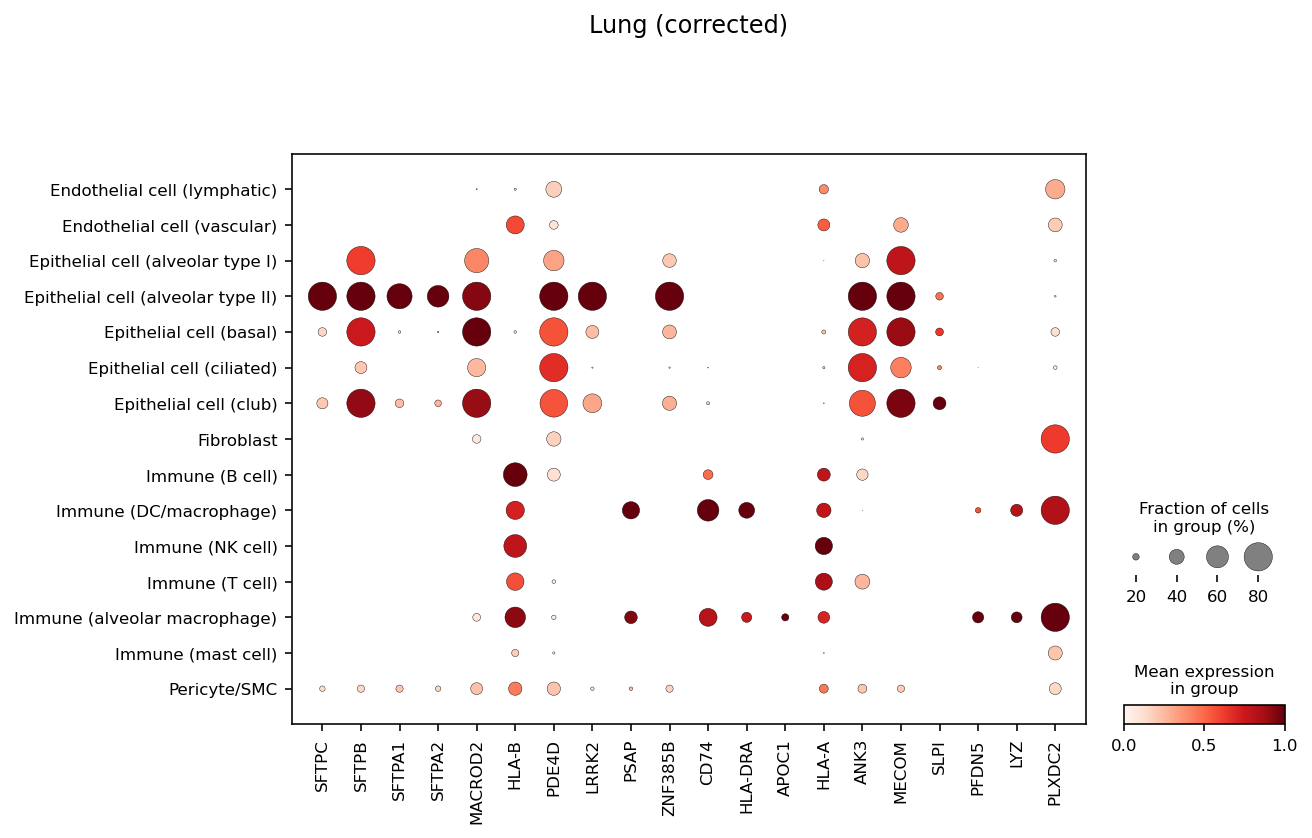

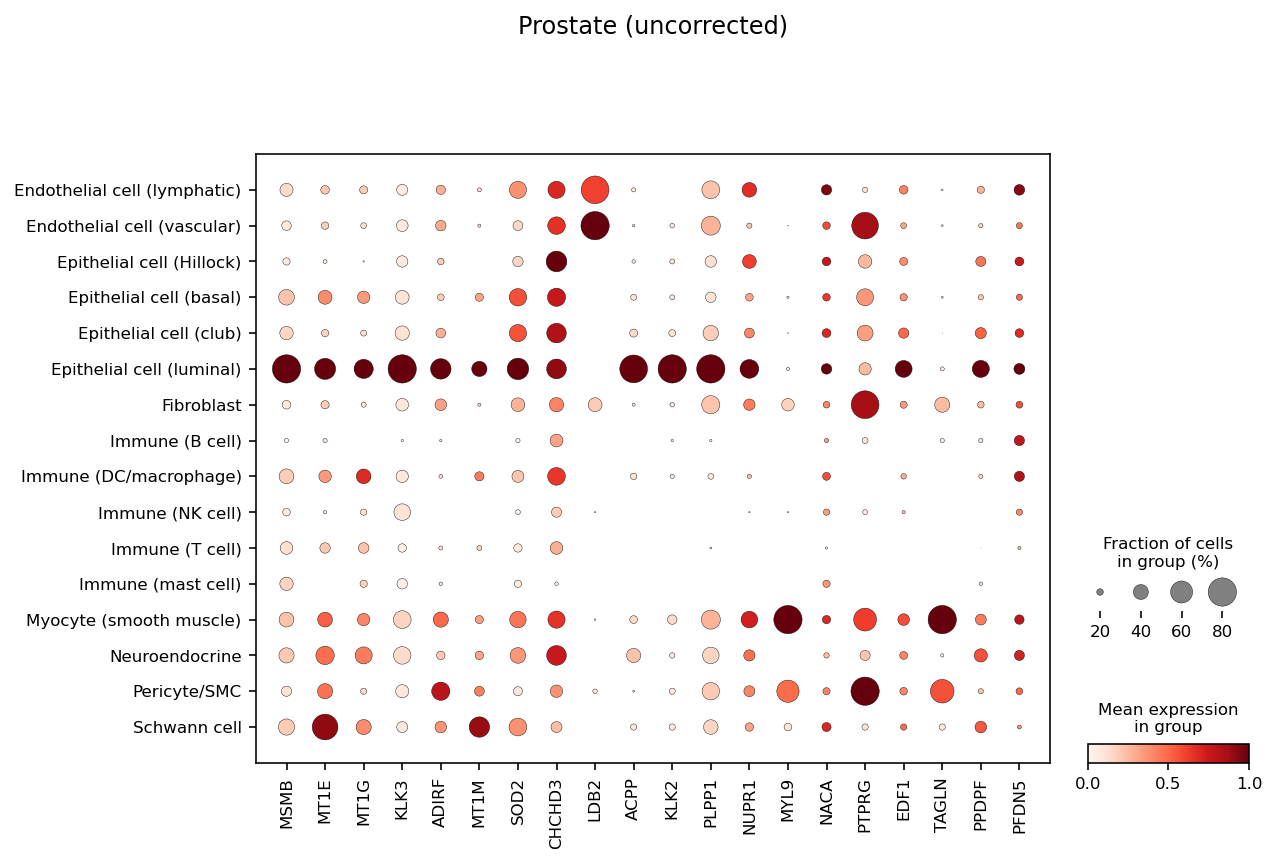

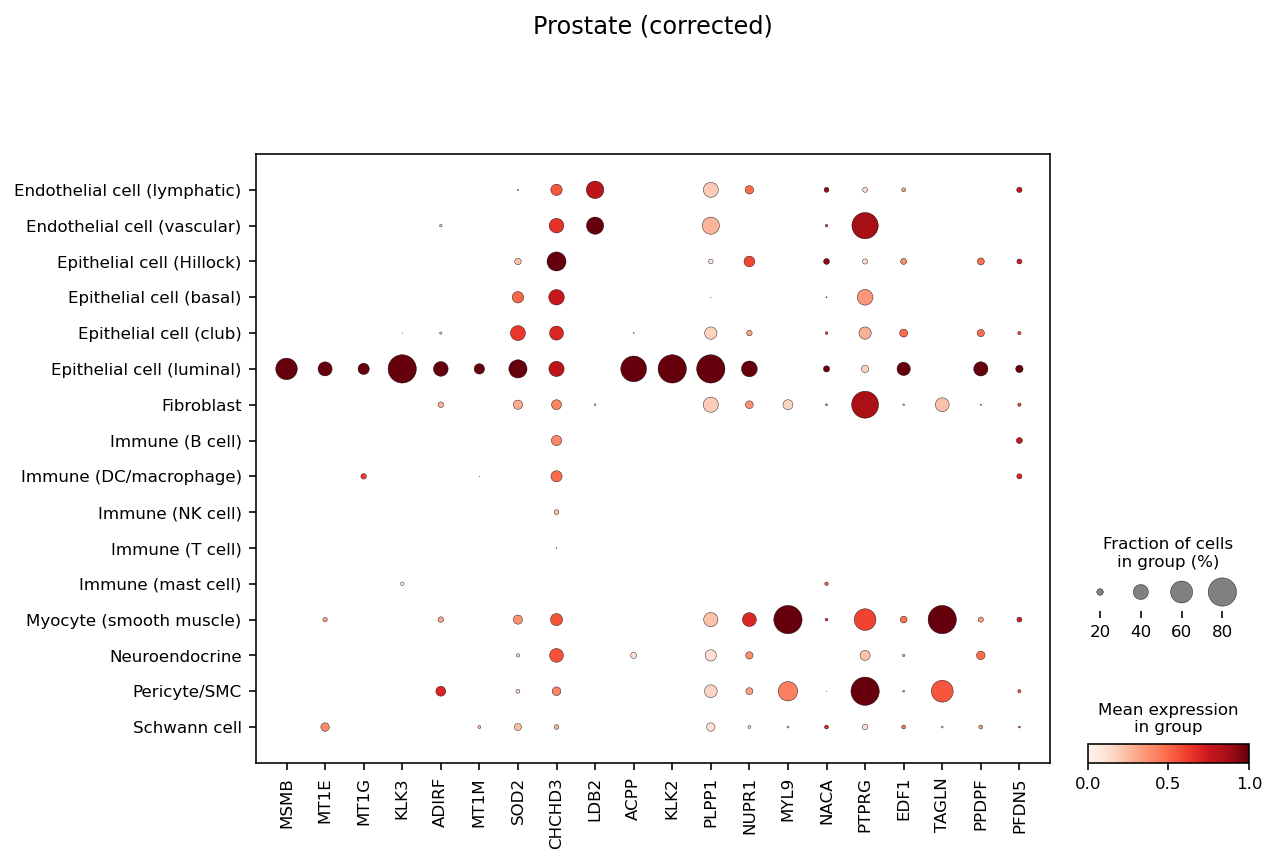

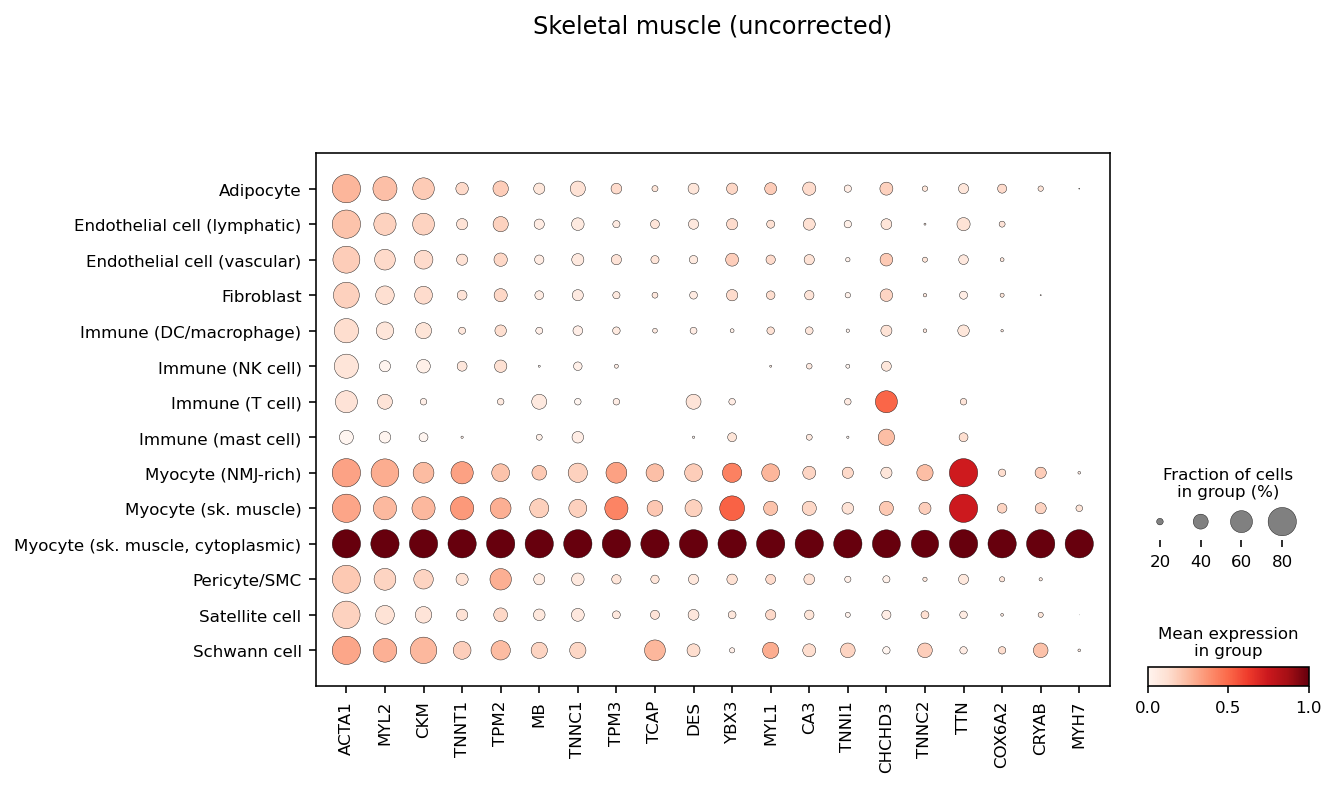

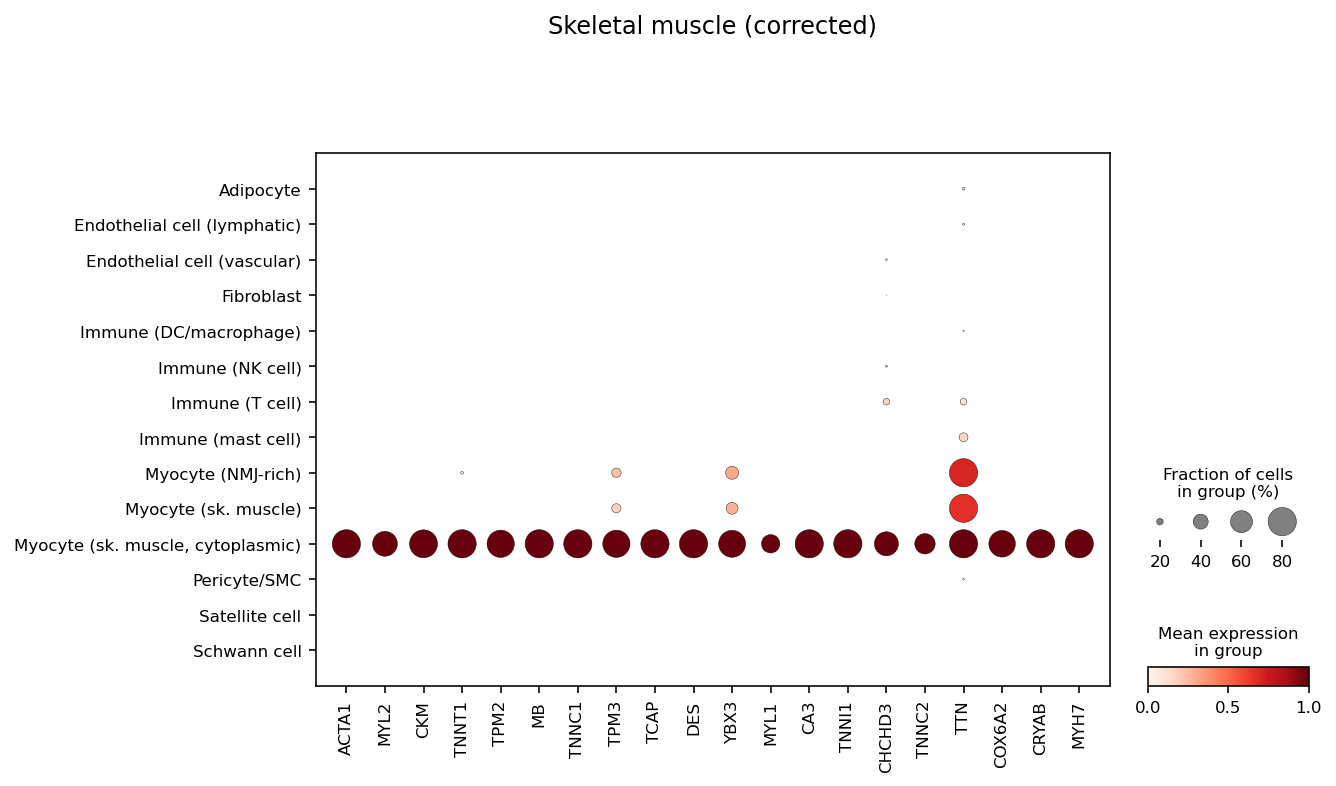

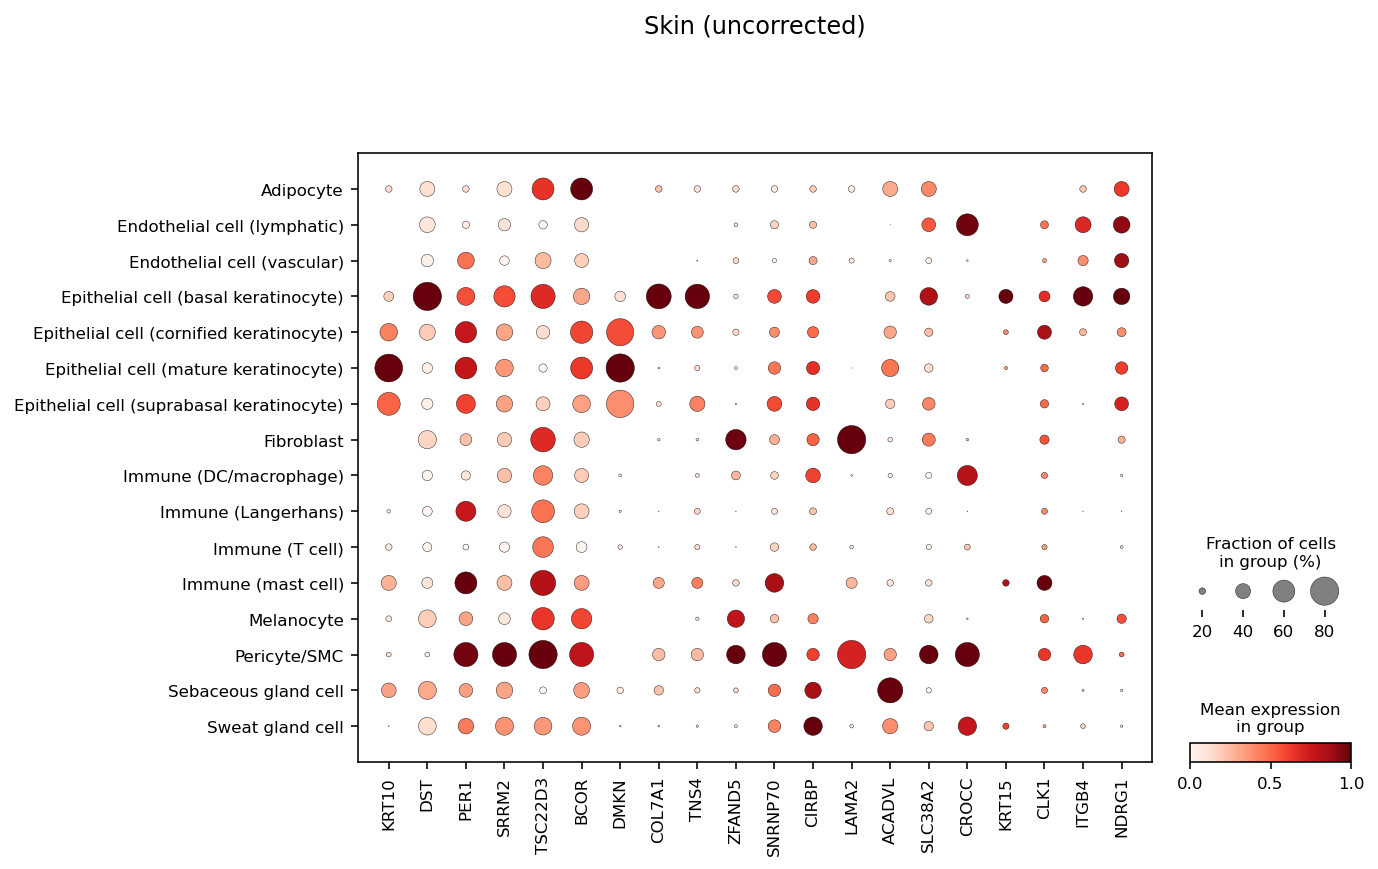

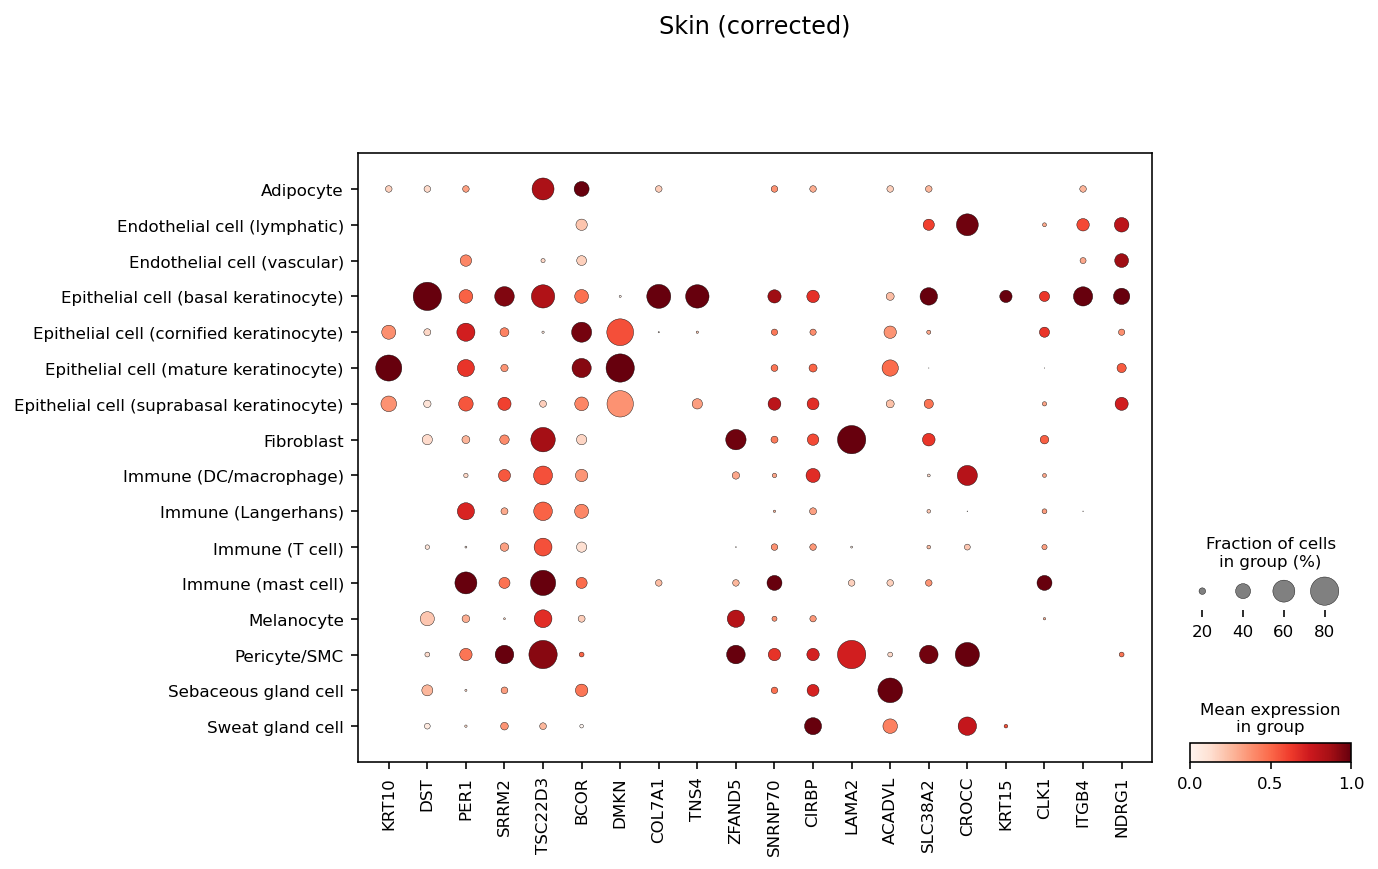

In [67]:
for i, t in enumerate(ad.obs.Tissue.cat.categories):

    genes = top20[top20.Tissue == t].gene.tolist()[:20]
    letter = string.ascii_uppercase[3:][i]
    sc.pl.dotplot(ad_old[(ad.obs.Tissue == t) & (ad.obs['Broad cell type']!='Unknown')], var_names=genes, groupby=['Broad cell type'], dot_max=.8, dot_min=.1, standard_scale='var', title=f'{t} (uncorrected)', save=f'Figure-S01-7{letter}-1.pdf')
    sc.pl.dotplot(ad[(ad.obs.Tissue == t) & (ad.obs['Broad cell type']!='Unknown')], var_names=genes, groupby=['Broad cell type'], dot_max=.8, dot_min=.1, standard_scale='var', title=f'{t} (corrected)', save=f'Figure-S01-7{letter}-2.pdf')

In [69]:
%%bash 

for x in figures/dotplot_Figure*
do mv $x ${x/dotplot_Figure/Figure}
done